In [1]:
# Adapted from Interstellar Technologies Inc. All Rights Reserved.

from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
from OpenGoddard.optimize import Problem, Guess, Condition, Dynamics
import pandas as pd

class Rocket:
    g0 = 9.80665  # Gravitational acceleration on Earth surface [m/s^2]

    def __init__(self):
        
        
        self.M_dry = 43 + 4  # dry mass [kg]
        self.M_prop = 18     # propellant mass [kg]
        
        self.M_0 = self.M_dry + self.M_prop #launch mass [kg]
        
        
        self.r = (6*25.4*0.001/2) # body tube radius, [m]
        self.sref = np.pi*self.r**2  # area [m2]
        
        
        self.Isp = 200.0  # Isp [s]
        
        self.thrust_to_weight = 11  # initial thrust to weight ratio
        self.T_max = self.thrust_to_weight * self.M_0 * self.g0

    def air_density(self, h):
        beta = 1/8500.0  # scale factor [1/m]
        rho0 = 1.225  # kg/m3
        return rho0*np.exp(-beta*h)
    
    def speed_of_sound(self, h):
        #assumes h  is in meters, returns in m/s
        #determined from https://www.engineeringtoolbox.com/elevation-speed-sound-air-d_1534.html
        return -0.00389*h + 340.31598
    
    def drag(self, h, V):
        
        rho = self.air_density(h)
        a   = self.speed_of_sound(h)
        M   = V/a
        cd  = self.drag_coeff(M)
        
        q = (1/2)*rho*V**2
        
        drag = q*self.sref*cd
        
        return drag
        
    def drag_coeff(self, M):
        #polynomials determined from open_rocket export of rocket sized like U waterloo's 2018 rocket.
        #reference area is the rocket cross section. Data generated for 6 in diameter body tube. 
        
        def drag_coeff_single(M):
            
            coeff_sub = [ 0.62974538, -0.01151512,  0.11773826]
            coeff_tra = [-3.52610503,  7.99357459, -3.72820877]
            coeff_sup = [ 1.09641739, -0.45894398,  0.07741472]
            
            if M<1:
                coeff = coeff_sub
            elif M>1.25:
                coeff = coeff_sup
            else:
                coeff = coeff_tra
                
            cd = np.polynomial.polynomial.polyval(M,coeff)
            
            return cd
        
        M = np.array(M)
        
        if M.size == 1:
            #act on a single data point
            return drag_coeff_single(M)
        
        else:
            #assumes M is a vector
            cd = np.array([drag_coeff_single(mi) for mi in M])
            return cd

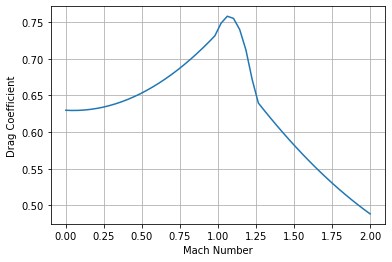

In [2]:
#verify drag model
rocket = Rocket()
M =np.linspace(0,2)
cds=rocket.drag_coeff(M)
plt.plot(M,cds)
plt.grid(True)
plt.xlabel('Mach Number')
plt.ylabel('Drag Coefficient');

In [3]:
rocket.T_max

7011.754749999999

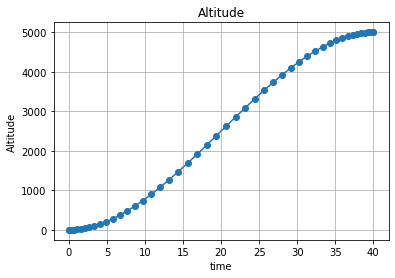

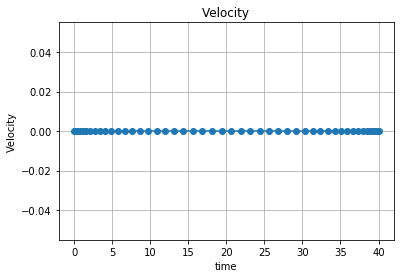

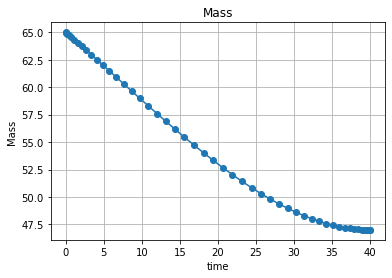

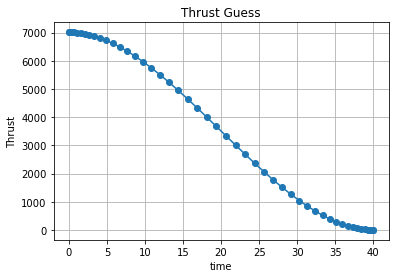

In [6]:
def dynamics(prob, obj, section):
    h = prob.states(0, section)
    v = prob.states(1, section)
    m = prob.states(2, section)
    
    T = prob.controls(0, section)
    
    drag = obj.drag(h,v)

    Isp = obj.Isp
    g0  = obj.g0
    
    dx = Dynamics(prob, section)
    dx[0] = v
    dx[1] = (T - drag) / m - g0
    dx[2] = - T / (Isp*g0)
    
    return dx()


def equality(prob, obj):
    h = prob.states_all_section(0)
    v = prob.states_all_section(1)
    m = prob.states_all_section(2)
    T = prob.controls_all_section(0)
    
    tf = prob.time_final(-1)

    result = Condition()

    # event condition
    result.equal(h[0], 0.0)
    result.equal(v[0], 0.0)
    result.equal(m[0], obj.M_0)
    result.equal(v[-1], 0.0)
    result.equal(m[-1], obj.M_dry)
    
    #find index around h = 5m
    

    return result()


def inequality(prob, obj):
    h = prob.states_all_section(0)
    v = prob.states_all_section(1)
    m = prob.states_all_section(2)
    T = prob.controls_all_section(0)
    tf = prob.time_final(-1)

    result = Condition()
    # lower bounds
    result.lower_bound(h, 0)
    result.lower_bound(v, 0.0)
    result.lower_bound(m, obj.M_dry)
    result.lower_bound(T, 0.0)
    result.lower_bound(tf, 10)
    # upper bounds
    result.upper_bound(m, obj.M_0)
    result.upper_bound(T, obj.T_max)
    
    #require launch rail clearance speed requirement
    #idx = np.abs(h - 5).argmin() #get time index of launch speed
    #result.lower_bound(v[idx], 30.5)
    #this method didnt work. will think of something better.
    
    #impose a minimum thrust for the first few seconds
    #v_min = 30.5 #minimum launch rail clearance speed
    #s = 5 #launch rail length
    #a_min = v_min**2/(2*s)
    #F_min = a_min*obj.M_0
    #t_min = v_min/a_min
    
    #F_min_vector = np.zeros_like(h)
    #idx = np.abs(h - s).argmin()
    #F_min_vector[0:(idx+1)] = F_min
    
    #result.lower_bound(T, F_min_vector)

    
    result.lower_bound(T[0], obj.T_max)
    result.lower_bound(T[1], obj.T_max)
    result.lower_bound(T[2], obj.T_max)
    result.lower_bound(T[3], obj.T_max)
    #result.lower_bound(T[4], obj.T_max)
    
    return result()


def cost(prob, obj):
    h = prob.states_all_section(0)
    return - h[-1]#/3000 #bring value closer to 1


def cost_derivative(prob, obj):
    jac = Condition(prob.number_of_variables)
    index_h_end = prob.index_states(0, 0, -1)
    jac.change_value(index_h_end, -1)
    return jac()



time_init = [0.0, 40]
n = [50]
num_states = [3]
num_controls = [1]
max_iteration = 10

flag_savefig = True
savefig_file = "./Basic_Single_Stage/"

# ------------------------
# set OpenGoddard class for algorithm determination
prob = Problem(time_init, n, num_states, num_controls, max_iteration)

# ------------------------
# create instance of operating object
obj = Rocket()

# ------------------------
# set designer unit
#unit_R = obj.Re
#unit_v = np.sqrt(obj.GMe / obj.Re)
#unit_m = obj.M0
#unit_t = unit_R / unit_v
#unit_T = unit_m * unit_R / unit_t**2
#prob.set_unit_states_all_section(0, unit_R)
#prob.set_unit_states_all_section(1, unit_v)
#prob.set_unit_states_all_section(2, unit_m)
#prob.set_unit_controls_all_section(0, unit_T)
#prob.set_unit_time(unit_t)

# ========================
# Initial parameter guess

# altitude profile
h_init = Guess.cubic(prob.time_all_section, 0, 0.0, 5000, 0.0)
Guess.plot(prob.time_all_section, h_init, "Altitude", "time", "Altitude")
# if(flag_savefig):plt.savefig(savefig_file + "guess_alt" + ".png")

# velocity
V_init = Guess.linear(prob.time_all_section, 0.0, 0.0)
Guess.plot(prob.time_all_section, V_init, "Velocity", "time", "Velocity")

# mass profile
M_init = Guess.cubic(prob.time_all_section, obj.M_0, -0.6, obj.M_dry, 0.0)
Guess.plot(prob.time_all_section, M_init, "Mass", "time", "Mass")
# if(flag_savefig):plt.savefig(savefig_file + "guess_mass" + ".png")

# thrust profile
T_init = Guess.cubic(prob.time_all_section, obj.T_max, 0.0, 0.0, 0.0)
Guess.plot(prob.time_all_section, T_init, "Thrust Guess", "time", "Thrust")
# if(flag_savefig):plt.savefig(savefig_file + "guess_mass" + ".png")

plt.show()


In [7]:
# ========================
# Substitution initial value to parameter vector to be optimized
prob.set_states_all_section(0, h_init)
prob.set_states_all_section(1, V_init)
prob.set_states_all_section(2, M_init)
prob.set_controls_all_section(0, T_init)

# ========================
# Main Process
# Assign problem to SQP solver
prob.dynamics = [dynamics]
prob.knot_states_smooth = []
prob.cost = cost
# prob.cost_derivative = cost_derivative
prob.equality = equality
prob.inequality = inequality


def display_func():
    h = prob.states_all_section(0)
    print("max altitude: {0:.5f} m".format(h[-1]))

prob.solve(obj, display_func, ftol=1e-12)



---- iteration : 1 ----
Iteration limit exceeded    (Exit mode 9)
            Current function value: -5259.504651438682
            Iterations: 26
            Function evaluations: 5278
            Gradient evaluations: 26
Iteration limit exceeded
max altitude: 5259.50465 m

---- iteration : 2 ----
Iteration limit exceeded    (Exit mode 9)
            Current function value: -5569.048789116853
            Iterations: 26
            Function evaluations: 5278
            Gradient evaluations: 26
Iteration limit exceeded
max altitude: 5569.04879 m

---- iteration : 3 ----
Iteration limit exceeded    (Exit mode 9)
            Current function value: -5865.277147754071
            Iterations: 26
            Function evaluations: 5278
            Gradient evaluations: 26
Iteration limit exceeded
max altitude: 5865.27715 m

---- iteration : 4 ----
Iteration limit exceeded    (Exit mode 9)
            Current function value: -6145.0853339266705
            Iterations: 26
            Function

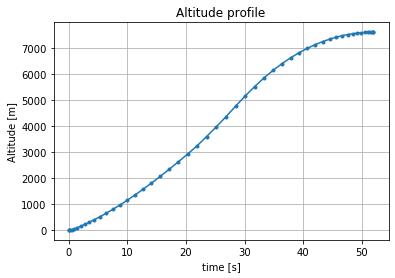

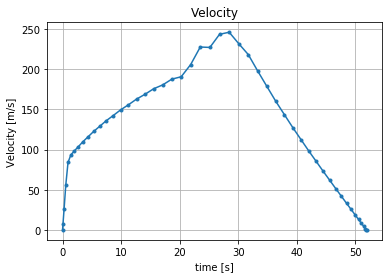

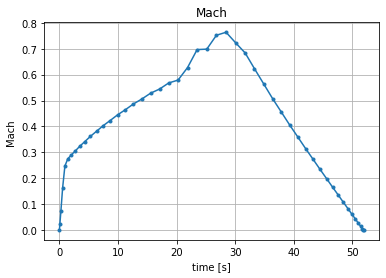

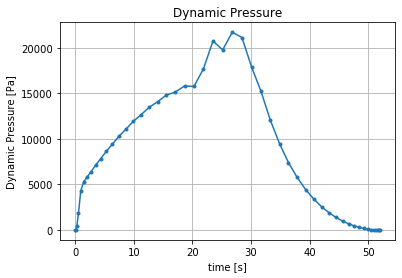

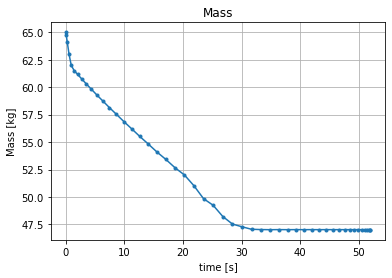

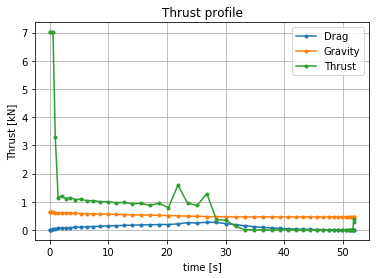

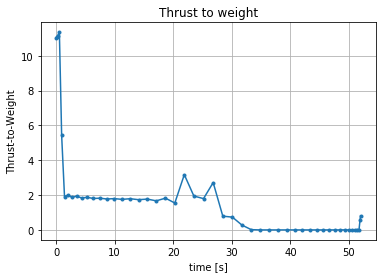

In [24]:

# ========================
# Post Process
# ------------------------
# Convert parameter vector to variable
h = prob.states_all_section(0)
v = prob.states_all_section(1)
m = prob.states_all_section(2)
T = prob.controls_all_section(0)
time = prob.time_update()

rho = obj.air_density(h)
q = (1/2)*rho*v**2
a = obj.speed_of_sound(h)
M = v/a

# ------------------------
# Calculate necessary variables

drag = obj.drag(h,v)
g0   = obj.g0

# ------------------------
# Visualizetion
plt.figure()
plt.title("Altitude profile")
plt.plot(time, h, marker=".", label="Altitude")
plt.grid()
plt.xlabel("time [s]")
plt.ylabel("Altitude [m]")
if(flag_savefig): plt.savefig(savefig_file + "altitude" + ".png")

plt.figure()
plt.title("Velocity")
plt.plot(time, v, marker=".", label="Velocity")
plt.grid()
plt.xlabel("time [s]")
plt.ylabel("Velocity [m/s]")
if(flag_savefig): plt.savefig(savefig_file + "velocity" + ".png")
    
plt.figure()
plt.title("Mach")
plt.plot(time, M, marker=".", label="Mach")
plt.grid()
plt.xlabel("time [s]")
plt.ylabel("Mach ")
if(flag_savefig): plt.savefig(savefig_file + "mach" + ".png")
    
plt.figure()
plt.title("Dynamic Pressure")
plt.plot(time, q, marker=".", label="Dynamic Pressure")
plt.grid()
plt.xlabel("time [s]")
plt.ylabel("Dynamic Pressure [Pa]")
if(flag_savefig): plt.savefig(savefig_file + "dynamicPressure" + ".png")

plt.figure()
plt.title("Mass")
plt.plot(time, m, marker=".", label="Mass")
plt.grid()
plt.xlabel("time [s]")
plt.ylabel("Mass [kg]")
if(flag_savefig): plt.savefig(savefig_file + "mass" + ".png")

plt.figure()
plt.title("Thrust profile")
plt.plot(time, drag / 1000, marker=".", label="Drag")
plt.plot(time, m * g0 / 1000, marker=".", label="Gravity")
plt.plot(time, T / 1000, marker=".", label="Thrust")
plt.grid()
plt.xlabel("time [s]")
plt.ylabel("Thrust [kN]")
plt.legend(loc="best")
if(flag_savefig): plt.savefig(savefig_file + "force" + ".png")
    
plt.figure()
plt.title("Thrust to weight")
plt.plot(time, T/(m*g0), marker=".")
plt.grid()
plt.xlabel("time [s]")
plt.ylabel("Thrust-to-Weight")
if(flag_savefig): plt.savefig(savefig_file + "T-to-W" + ".png")

plt.show()

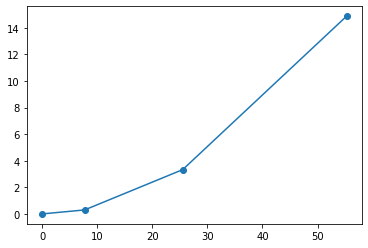

In [18]:
plt.plot(v[h<20],h[h<20],'o-')


In [21]:
h

array([0.00000000e+00, 3.00560244e-01, 3.33386099e+00, 1.48793899e+01,
       4.27195577e+01, 8.68120770e+01, 1.43148988e+02, 2.12342377e+02,
       2.95318376e+02, 3.93372133e+02, 5.07232272e+02, 6.37934074e+02,
       7.85973874e+02, 9.51967995e+02, 1.13609311e+03, 1.33861903e+03,
       1.55931761e+03, 1.79815906e+03, 2.05435179e+03, 2.32701726e+03,
       2.61476677e+03, 2.91719607e+03, 3.23417366e+03, 3.59151326e+03,
       3.96563765e+03, 4.35116882e+03, 4.75817698e+03, 5.14831364e+03,
       5.51324563e+03, 5.84551720e+03, 6.14031617e+03, 6.39941711e+03,
       6.62507688e+03, 6.81972386e+03, 6.98566478e+03, 7.12531814e+03,
       7.24106683e+03, 7.33536530e+03, 7.41064158e+03, 7.46932716e+03,
       7.51379195e+03, 7.54633964e+03, 7.56916494e+03, 7.58432051e+03,
       7.59365987e+03, 7.59883769e+03, 7.60127807e+03, 7.60214245e+03,
       7.60228332e+03, 7.60229544e+03])

In [19]:
v

array([0.00000000e+00, 7.71302002e+00, 2.55196684e+01, 5.52678279e+01,
       8.40013274e+01, 9.33550275e+01, 9.82905704e+01, 1.03533964e+02,
       1.09672941e+02, 1.15723406e+02, 1.22413667e+02, 1.28848971e+02,
       1.35803984e+02, 1.42255359e+02, 1.49306117e+02, 1.55596241e+02,
       1.62673581e+02, 1.68649477e+02, 1.75578967e+02, 1.80317493e+02,
       1.87507591e+02, 1.90479250e+02, 2.05642307e+02, 2.27435162e+02,
       2.26954069e+02, 2.43278646e+02, 2.45826285e+02, 2.31578831e+02,
       2.18099476e+02, 1.97850172e+02, 1.78656599e+02, 1.60021522e+02,
       1.43221173e+02, 1.27048364e+02, 1.12272457e+02, 9.81321976e+01,
       8.51788730e+01, 7.28905808e+01, 6.16955465e+01, 5.12057891e+01,
       4.17832492e+01, 3.31055578e+01, 2.55232291e+01, 1.87240134e+01,
       1.30235567e+01, 8.13017701e+00, 4.45400831e+00, 1.56693789e+00,
       2.11381418e-01, 0.00000000e+00])

In [20]:
T

array([ 7.01175475e+03,  7.01175475e+03,  7.01175475e+03,  7.01175475e+03,
        3.29728446e+03,  1.14858349e+03,  1.20636395e+03,  1.11098087e+03,
        1.14680073e+03,  1.07657313e+03,  1.08813050e+03,  1.03916394e+03,
        1.03865342e+03,  1.00089637e+03,  1.00200700e+03,  9.66459346e+02,
        9.74883755e+02,  9.32948795e+02,  9.38272273e+02,  8.74215734e+02,
        9.41404431e+02,  7.87232879e+02,  1.58709924e+03,  9.50245791e+02,
        8.67597925e+02,  1.28477636e+03,  3.67757822e+02,  3.40347014e+02,
        1.29171317e+02,  7.02734136e+00, -1.51309520e-13,  1.11040517e-13,
       -3.10432235e-13,  1.41425209e-01,  3.91670203e-14,  6.74113543e-15,
        3.99819067e-14,  2.46911691e-02,  3.83304499e-14,  2.27811217e-01,
        1.27432787e-13,  4.78096453e-01,  1.59199674e+00,  2.52450601e-01,
        3.64244225e-14,  6.63006867e-13,  1.09167325e+01,  9.94404212e-14,
        2.70245584e+02,  3.73609420e+02])

In [12]:
v_min = 30.5 #minimum launch rail clearance speed
s = 5 #launch rail length
a_min = v_min**2/(2*s)
F_min = a_min*obj.M_0
t_min = v_min/a_min

In [13]:
F_min

6046.625

In [14]:
obj.T_max

7011.754749999999

In [15]:
T

array([ 7.01175475e+03,  7.01175475e+03,  7.01175475e+03,  7.01175475e+03,
        3.29728446e+03,  1.14858349e+03,  1.20636395e+03,  1.11098087e+03,
        1.14680073e+03,  1.07657313e+03,  1.08813050e+03,  1.03916394e+03,
        1.03865342e+03,  1.00089637e+03,  1.00200700e+03,  9.66459346e+02,
        9.74883755e+02,  9.32948795e+02,  9.38272273e+02,  8.74215734e+02,
        9.41404431e+02,  7.87232879e+02,  1.58709924e+03,  9.50245791e+02,
        8.67597925e+02,  1.28477636e+03,  3.67757822e+02,  3.40347014e+02,
        1.29171317e+02,  7.02734136e+00, -1.51309520e-13,  1.11040517e-13,
       -3.10432235e-13,  1.41425209e-01,  3.91670203e-14,  6.74113543e-15,
        3.99819067e-14,  2.46911691e-02,  3.83304499e-14,  2.27811217e-01,
        1.27432787e-13,  4.78096453e-01,  1.59199674e+00,  2.52450601e-01,
        3.64244225e-14,  6.63006867e-13,  1.09167325e+01,  9.94404212e-14,
        2.70245584e+02,  3.73609420e+02])

In [16]:
np.trapz(x= time, y = T)

35409.05531021503

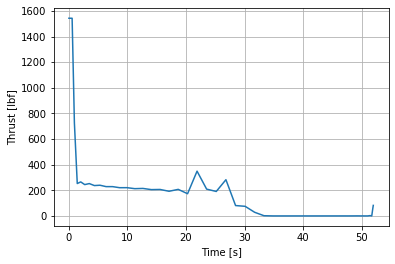

In [26]:
plt.plot(time,T*0.22)
plt.xlabel('Time [s]')
plt.ylabel('Thrust [lbf]')
plt.grid()